env: JAX_PLATFORM_NAME=cuda


CUDA backend failed to initialize: jaxlib/cuda/versions_helpers.cc:98: operation cuInit(0) failed: CUDA_ERROR_UNKNOWN (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


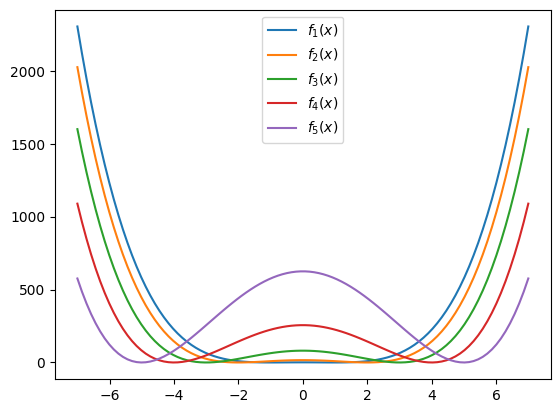

In [1]:
import jax


%env JAX_PLATFORM_NAME=cuda

from test.helpers import _batch_sde_solve_multi_y0

import diffrax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from diffrax import (
    LangevinTerm,
    SORT,
)
from drawing_and_evaluating import (
    constant_step_strong_order,  # noqa: F401
    pid_strong_order,  # noqa: F401
)


def f_n(n):
    return lambda x: (x - n) ** 2 * (x + n) ** 2


f_list = [f_n(n) for n in range(1, 6)]

# plot the functions
x = jnp.linspace(-7, 7, 100)
for i in range(1, 6):
    f = f_list[i - 1]
    plt.plot(x, f(x), label=f"$f_{i}(x)$")
plt.legend()

In [3]:
num_samples = 4000
xs0 = -10 * jnp.ones((num_samples,), jnp.float32)
ys0 = (xs0, jnp.zeros((num_samples,), jnp.float32))
t0 = 0.0
T = 2**6
dt0 = 0.25
controller = diffrax.PIDController(
    rtol=0,
    atol=2.0,
    pcoeff=0.2,
    icoeff=0.6,
    dcoeff=0,
    dtmin=2**-6,
    dtmax=1.0,
)

w_shape = ()
levy_area = diffrax.SpaceTimeTimeLevyArea
bm_tol = 2**-8

gamma, u = 1.0, 1.0

key = jr.key(777)
half_sort = diffrax.HalfSolver(SORT(0.1))

In [4]:
xss = [xs0]
for i in range(1, 6):
    key, subkey = jr.split(key, 2)
    keys = jr.split(subkey, num_samples)
    f = f_list[i - 1]
    grad_f = jax.grad(f)
    args = (gamma, u, grad_f)

    def get_terms(bm):
        return LangevinTerm(args, bm, xs0[0])

    ys = (xss[-1], jnp.zeros((num_samples,), jnp.float32))
    t1 = 2 * T if i == 1 else T
    ys_next, num_steps = _batch_sde_solve_multi_y0(
        keys,
        get_terms,
        w_shape,
        t0,
        t1,
        ys,
        None,
        half_sort,
        levy_area,
        dt0,
        controller,
        bm_tol,
        diffrax.SaveAt(t1=True),
        use_progress_meter=True,
    )
    print(f"iter {i}, num_steps: {jnp.mean(num_steps)}")
    xs_next, vs = ys_next
    xs_next = jnp.squeeze(xs_next)
    xss.append(xs_next)

100.00%|██████████| [00:04<00:00, 21.98%/s]


iter 1, num_steps: 938.2133178710938


100.00%|██████████| [00:02<00:00, 49.01%/s]


iter 2, num_steps: 411.2400207519531


100.00%|██████████| [00:03<00:00, 33.18%/s]


iter 3, num_steps: 523.644775390625


100.00%|██████████| [00:03<00:00, 25.47%/s]


iter 4, num_steps: 676.2037963867188


100.00%|██████████| [00:05<00:00, 19.99%/s]

iter 5, num_steps: 850.4430541992188


iter 1, proportion of xs < 0: 0.4907500147819519
iter 2, proportion of xs < 0: 0.4880000352859497
iter 3, proportion of xs < 0: 0.4880000352859497
iter 4, proportion of xs < 0: 0.4880000352859497
iter 5, proportion of xs < 0: 0.4880000352859497


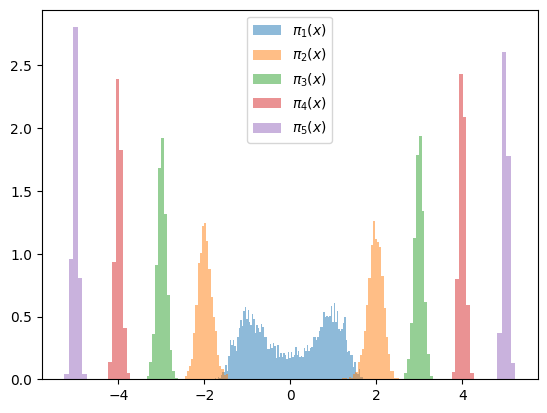

In [6]:
# draw the density of ys
for i in range(1, 6):
    xs = xss[i]
    plt.hist(xs, bins=100, density=True, alpha=0.5, label=f"$\pi_{i}(x)$")
    print(f"iter {i}, proportion of xs < 0: {jnp.mean(xs < 0)}")

plt.legend()